In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
#(224, 224, 3)
ih, iw = 224,224 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size


Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
from keras.applications import vgg16 
from keras.models import Model 
import keras 


vgg = vgg16.VGG16(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-5].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 

 
vgg_model.trainable = False
#set_trainable = False
 
#for layer in vgg_model.layers: 
#    if layer.name in ['block5_conv1', 'block4_conv1']: 
#        set_trainable = True 
#    if set_trainable: 
#        layer.trainable = True 
#    else: 
#        layer.trainable = False 

In [6]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x00000228CEAC4588>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x00000228CEAADA08>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x00000228CEAAAD48>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x00000228CF440A08>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x00000228CF440DC8>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x00000228CF44FD08>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x00000228CF454C08>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x00000228CF454808>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x00000228CF45E648>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x00000228CF461588>,block3_conv3,True


In [7]:
from os import listdir
from os.path import isfile,isdir, join
import numpy

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split

In [8]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers  
import tensorflow as tf

# build model architecture 
model = Sequential() 

model.add(vgg_model) 
model.add(Dense(1024, activation='relu', input_dim=input_shape)) 
model.add(Dropout(0.25)) 
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(num_class, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            7635264   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)              

In [21]:
history = model.fit_generator(train, steps_per_epoch=8, 
                              epochs=30,  
                              validation_data=val,   
                              validation_steps=8,  
                              verbose=1)

Epoch 1/30
8/8 [==============================] - 2s 302ms/step - loss: 0.6987 - accuracy: 0.5664 - f1_m: 0.4408 - precision_m: 0.5261 - recall_m: 0.3828 - val_loss: 0.6186 - val_accuracy: 0.5273 - val_f1_m: 0.5193 - val_precision_m: 0.5508 - val_recall_m: 0.4922
Epoch 2/30
8/8 [==============================] - 2s 227ms/step - loss: 0.6392 - accuracy: 0.6367 - f1_m: 0.5785 - precision_m: 0.6588 - recall_m: 0.5195 - val_loss: 0.6496 - val_accuracy: 0.6484 - val_f1_m: 0.5603 - val_precision_m: 0.7493 - val_recall_m: 0.4492
Epoch 3/30
8/8 [==============================] - 2s 226ms/step - loss: 0.5615 - accuracy: 0.7539 - f1_m: 0.5848 - precision_m: 0.8498 - recall_m: 0.4531 - val_loss: 0.4862 - val_accuracy: 0.7461 - val_f1_m: 0.7398 - val_precision_m: 0.7501 - val_recall_m: 0.7305
Epoch 4/30
8/8 [==============================] - 2s 226ms/step - loss: 0.5443 - accuracy: 0.7695 - f1_m: 0.7532 - precision_m: 0.7221 - recall_m: 0.7969 - val_loss: 0.5307 - val_accuracy: 0.8203 - val_f1_m: 

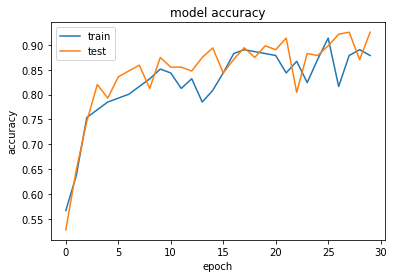

In [22]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

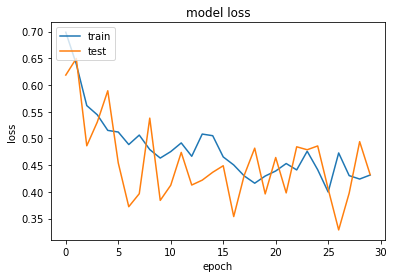

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

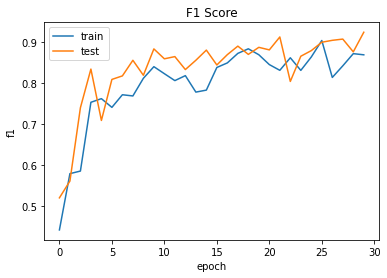

In [24]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

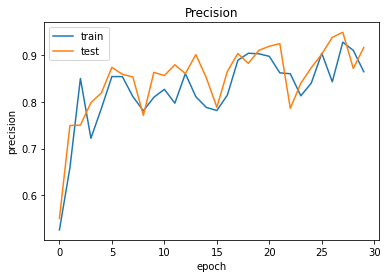

In [25]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

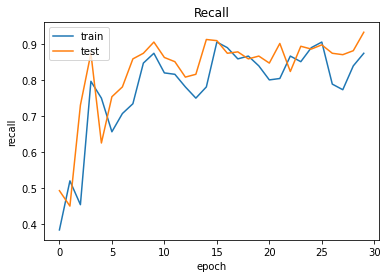

In [26]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

142/142 [==============================] - 17s 122ms/step
El modelo predice el  92.39250421524048 % de los datos


In [28]:
articulo_dir='D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'
#Para el conjunto del artículo
articulo_generator = train_datagen.flow_from_directory(
    articulo_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
articulo=articulo_generator

Found 351 images belonging to 2 classes.


In [29]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos del artículo para evaluar el modelo
11/11 [==============================] - 5s 428ms/step
El modelo predice el  85.47008633613586 % de los datos


In [30]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
142/142 [==============================] - 16s 109ms/step
El modelo predice el  92.39250421524048 % de los datos


In [31]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.37212997674942017
Accuracy:  0.9239250421524048
F1 Score:  0.9215515851974487
Precision:  0.9015684723854065
Recall:  0.9431357383728027


In [32]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos del artículo para evaluar el modelo
11/11 [==============================] - 5s 438ms/step
El modelo predice el  85.47008633613586 % de los datos


In [33]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos del artículo para evaluar el modelo
Loss:  0.3957382142543793
Accuracy:  0.8547008633613586
F1 Score:  0.8563160300254822
Precision:  0.8266273140907288
Recall:  0.8890212774276733
